# Amplification Factor Comparison

We consider the advection equation with constant velocity given by 

$$
\partial u_t + c\partial u_x = 0
$$
where $c \in \mathbb{R}$. We use the central second order finite difference discretisation for the spatial derivative, giving us 
$$
\partial u_x = \frac{u_{j+1} - u_{j-1}}{2 \Delta x}
$$
Then assuming a solution of the form $u = \phi (t) e^{ikx}$, we get the following:
$$
\frac{\mathrm{d}\phi}{\mathrm{d}t} = -ick' \phi
$$
where $k' = \frac{\sin(k\Delta x)}{\Delta x}$
Applying the backwards Euler step, we get
$$
\phi^{n+1} = \frac{1}{1 + ick'\Delta t}\phi^n
$$
Noting that $0 \leq k' \leq \frac{1}{\Delta x}$, we bound the amplification factor by:
$$
\frac{1}{1 + ic\frac{\Delta t}{\Delta x}} \leq G \leq 1
$$
Hence,
$$
\frac{1}{1+c^2\frac{\Delta t^2}{\Delta x^2}}\sqrt{1+c^2\frac{\Delta t^2}{\Delta x^2}} \leq |G| \leq 1
$$

In [45]:
from math import pi
nt = 256
nx = 128

lx = 2*pi
dx = lx/nx

theta = 1

c = 1
dt = 0.01


In [46]:
import numpy as np
mesh = np.linspace(start=-lx/2, stop=lx/2, num=nx, endpoint=False)

In [47]:
from scipy import sparse

# Finite difference spatial discretisations                                                                                                                                                   
def gradient_stencil(grad, order):                                                                                                                                                            
    '''                                                                                                                                                                                       
    Return the centred stencil for the `grad`-th gradient                                                                                                                                     
    of order of accuracy `order`                                                                                                                                                              
    '''                                                                                                                                                                                       
    return {                                                                                                                                                                                  
        1: {  # first gradient                                                                                                                                                                
            2: np.array([-1/2, 0, 1/2]),                                                                                                                                                      
            4: np.array([1/12, -2/3, 0, 2/3, -1/12]),                                                                                                                                         
            6: np.array([-1/60, 3/20, -3/4, 0, 3/4, -3/20, 1/60])                                                                                                                             
        },                                                                                                                                                                                    
        2: {  # second gradient                                                                                                                                                               
            2: np.array([1, -2, 1]),                                                                                                                                                          
            4: np.array([-1/12, 4/3, -5/2, 4/3, -1/12]),                                                                                                                                      
            6: np.array([1/90, -3/20, 3/2, -49/18, 3/2, -3/20, 1/90])                                                                                                                         
        },                                                                                                                                                                                    
        4: {  # fourth gradient                                                                                                                                                               
            2: np.array([1,  -4, 6, -4, 1]),                                                                                                                                                  
            4: np.array([-1/6, 2, -13/2, 28/3, -13/2, 2, -1/6]),                                                                                                                              
            6: np.array([7/240, -2/5, 169/60, -122/15, 91/8, -122/15, 169/60, -2/5, 7/240])  # noqa: E501                                                                                     
        }                                                                                                                                                                                     
    }[grad][order]                                                                                                                                                                            
                                                                                                                                                                                              
                                                                                                                                                                                              
def sparse_circulant(stencil, n):                                                                                                                                                             
    '''                                                                                                                                                                                       
    Return sparse scipy matrix from finite difference                                                                                                                                         
    stencil on a periodic grid of size n.                                                                                                                                                     
    '''                                                                                                                                                                                       
    if len(stencil) == 1:                                                                                                                                                                     
        return sparse.spdiags([stencil[0]*np.ones(n)], 0)                                                                                                                                     
                                                                                                                                                                                              
    # extend stencil to include periodic overlaps                                                                                                                                             
    ns = len(stencil)                                                                                                                                                                         
    noff = (ns-1)//2                                                                                                                                                                          
    pstencil = np.zeros(ns+2*noff)                                                                                                                                                            
                                                                                                                                                                                              
    pstencil[noff:-noff] = stencil                                                                                                                                                            
    pstencil[:noff] = stencil[noff+1:]                                                                                                                                                        
    pstencil[-noff:] = stencil[:noff]                                                                                                                                                         
                                                                                                                                                                                              
    # constant diagonals of stencil entries                                                                                                                                                   
    pdiags = np.tile(pstencil[:, np.newaxis], n)                                                                                                                                              
                                                                                                                                                                                              
    # offsets for inner domain and periodic overlaps                                                                                                                                          
    offsets = np.zeros_like(pstencil, dtype=int)                                                                                                                                              
                                                                                                                                                                                              
    offsets[:noff] = [-n+1+i for i in range(noff)]                                                                                                                                            
    offsets[noff:-noff] = [-noff+i for i in range(2*noff+1)]                                                                                                                                  
    offsets[-noff:] = [n-noff+i for i in range(noff)]                                                                                                                                         
                                                                                                                                                                                              
    return sparse.spdiags(pdiags, offsets)

In [48]:
# Mass matrix (identity)
M = sparse_circulant([1], nx)

# Advection matrix
D = sparse_circulant(gradient_stencil(1, order=2), nx)

In [49]:
from scipy.sparse import linalg as spla

K = (c/dx)*D

A0 = -M/dt + (1 - theta)*K                                                                                                                                                                    
A1 = M/dt + theta*K                                                                                                                                                                           
A1.solve = spla.factorized(A1.tocsc())

In [50]:
# initial conditions                                                                                                                                                                          
qinit = np.zeros_like(mesh)                                                                                                                                                                   
qinit[:] = np.cos(mesh/2)**4                                                                                                                                                                  
                                                                                                                                                                                              
# calculate timeseries                                                                                                                                                                        
q = np.zeros((nt+1, len(qinit)))                                                                                                                                                              
q[0] = qinit                                                                                                                                                                                  
                                                                                                                                                                                              
for i in range(nt-1):                                                                                                                                                                         
    q[i+1] = A1.solve(-A0.dot(q[i]))

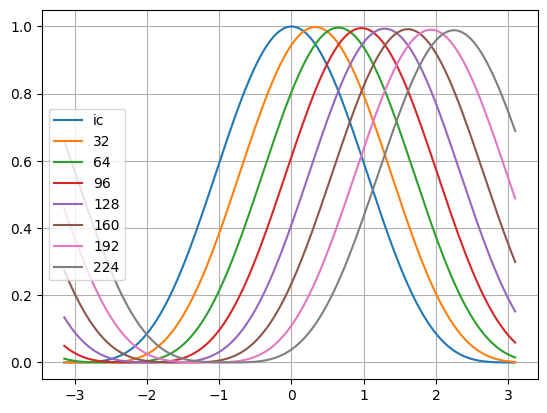

In [51]:
import matplotlib.pyplot as plt                                                                                                                                                           
nplot = 32
plt.plot(mesh, qinit, label='ic')                                                                                                                                                         
for i in range(nplot, nt, nplot):                                                                                                                                       
    plt.plot(mesh, q[i+1], label=str(i))                                                                                                                                                  
plt.legend(loc='center left')                                                                                                                                                             
plt.grid()

In [52]:
amp_factors = []
for i in range(nt-1):
    amp = np.linalg.norm(q[i+1]) / np.linalg.norm(q[i])
    amp_factors.append(amp)

In [53]:
lower_bound = 1/np.sqrt(1+c**2*(dt**2)/dx**2)

assert max(amp_factors) <= 1
assert min(amp_factors) >= lower_bound

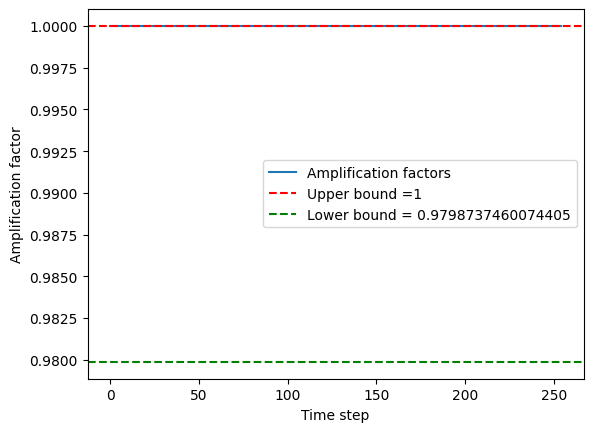

In [54]:
plt.plot(amp_factors, label='Amplification factors')

plt.axhline(1, color='r', linestyle='--', label='Upper bound =1')
plt.axhline(lower_bound, color='g', linestyle='--', label=f'Lower bound = {lower_bound}')

plt.xlabel('Time step')
plt.ylabel('Amplification factor')
plt.legend()
plt.show()


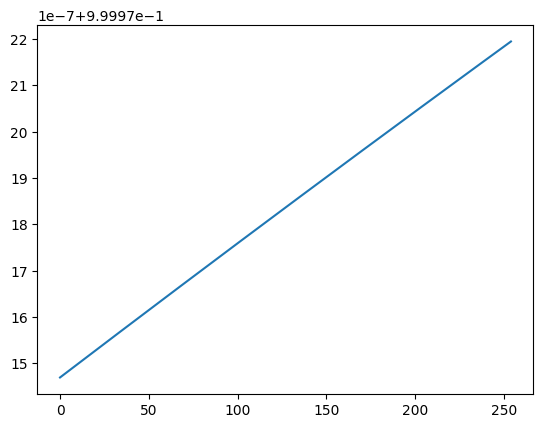

In [55]:
plt.plot(amp_factors)